In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import torchvision
import torch
from torch import nn
import timm
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam
from tqdm.notebook import tqdm
from timeit import default_timer as timer
from timm.layers import BatchNormAct2d
from torchvision import transforms
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Colab\ Notebooks/OOD2_dir
!ls

/content/drive/MyDrive/Colab Notebooks/OOD2_dir
 ba_ood_results_df.csv			  HRCTChestCovid_metadata.csv
 ba_ood_results_df_robust.csv		  mahalanobis_distances.pt
 buenos_aires_skin_lesion_images_all	  mobilenetv3b64_epoch_10.pth
 buenos_aires_skin_lesions_metadata.csv   mobilenetv3b64_epoch_1.pth
'class conditional Gaussian'		  mobilenetv3b64_epoch_2.pth
 combined_results.csv			  mobilenetv3b64_epoch_3.pth
 combined_results_robust.csv		  mobilenetv3b64_epoch_4.pth
'Copy of OOD2_Ruz'			  mobilenetv3b64_epoch_5.pth
 ct_ood_results_df.csv			  mobilenetv3b64_epoch_6.pth
 ct_ood_results_df_robust.csv		  mobilenetv3b64_epoch_7.pth
 features_stack.pt			  mobilenetv3b64_epoch_8.pth
 gaussian_covariance_matrix.pt		  mobilenetv3b64_epoch_9.pth
 gaussian_mean.pt			  OOD2_Ruz
 HAM10000_images_all			  resnet50_epoch_4.pth
 HAM10000_metadata.csv			  resnet50_epoch_7.pth
 HAM10000_metadata.gsheet		  robust_covariance_matrix.pt
 HRCTChestCovid_all			  robust_mahalanobis_distances.pt


In [5]:
metadata_df = pd.read_csv('HAM10000_metadata.csv')
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


Splitting data into train, validation, and test sets: %70 train, %15 validation, %15 test

In [6]:
train_df, temp_df = train_test_split(metadata_df, test_size=0.3, stratify=metadata_df['dx'], random_state=42)

In [7]:
print(train_df.size)
print(temp_df.size)

56080
24040


In [8]:
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

In [9]:
print(val_df.size)
print(test_df.size)

12016
12024


In [10]:
val_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,vidir_modern
4180,HAM_0000885,ISIC_0025293,nv,follow_up,40.0,female,upper extremity,vidir_molemax
3249,HAM_0004544,ISIC_0031099,nv,follow_up,50.0,male,foot,vidir_molemax
624,HAM_0002548,ISIC_0028656,bkl,histo,50.0,female,lower extremity,rosendahl
319,HAM_0007260,ISIC_0028336,bkl,histo,60.0,male,chest,rosendahl


In [11]:
val_df.reset_index(inplace = True)
val_df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,vidir_modern
1,4180,HAM_0000885,ISIC_0025293,nv,follow_up,40.0,female,upper extremity,vidir_molemax
2,3249,HAM_0004544,ISIC_0031099,nv,follow_up,50.0,male,foot,vidir_molemax
3,624,HAM_0002548,ISIC_0028656,bkl,histo,50.0,female,lower extremity,rosendahl
4,319,HAM_0007260,ISIC_0028336,bkl,histo,60.0,male,chest,rosendahl


In [12]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
547,HAM_0005335,ISIC_0031580,bkl,histo,40.0,male,upper extremity,rosendahl
8877,HAM_0006835,ISIC_0031594,nv,histo,75.0,male,chest,rosendahl
3696,HAM_0007205,ISIC_0026269,nv,follow_up,60.0,male,lower extremity,vidir_molemax
5850,HAM_0004072,ISIC_0032130,nv,follow_up,60.0,male,upper extremity,vidir_molemax
3371,HAM_0003341,ISIC_0027212,nv,follow_up,55.0,male,lower extremity,vidir_molemax


In [13]:
test_df.reset_index(inplace = True)
test_df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,547,HAM_0005335,ISIC_0031580,bkl,histo,40.0,male,upper extremity,rosendahl
1,8877,HAM_0006835,ISIC_0031594,nv,histo,75.0,male,chest,rosendahl
2,3696,HAM_0007205,ISIC_0026269,nv,follow_up,60.0,male,lower extremity,vidir_molemax
3,5850,HAM_0004072,ISIC_0032130,nv,follow_up,60.0,male,upper extremity,vidir_molemax
4,3371,HAM_0003341,ISIC_0027212,nv,follow_up,55.0,male,lower extremity,vidir_molemax


In [14]:
train_df['dx'].value_counts()

nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: dx, dtype: int64

In [15]:
val_df['dx'].value_counts()

nv       1006
mel       167
bkl       165
bcc        77
akiec      49
vasc       21
df         17
Name: dx, dtype: int64

In [16]:
test_df['dx'].value_counts()

nv       1006
mel       167
bkl       165
bcc        77
akiec      49
vasc       22
df         17
Name: dx, dtype: int64

Data Augmentation for training set only

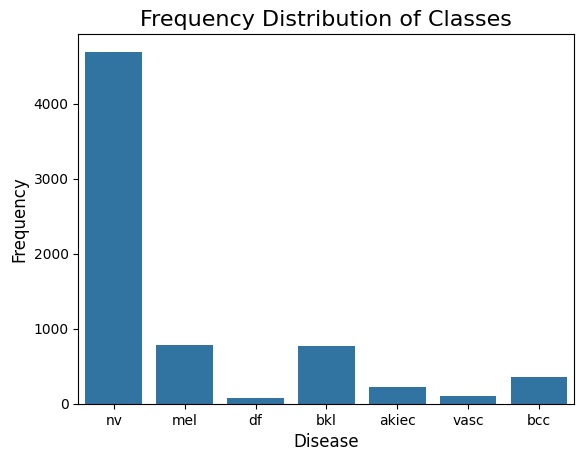

In [17]:
sns.countplot(x = 'dx', data = train_df)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

In [18]:
y = train_df['dx'];
x = train_df.drop(columns = ['dx']);

oversample = RandomOverSampler()
train_df_aug,y  = oversample.fit_resample(x,y)
train_df_aug['dx'] = y

In [19]:
train_df_aug['dx'].value_counts()

nv       4693
mel      4693
df       4693
bkl      4693
akiec    4693
vasc     4693
bcc      4693
Name: dx, dtype: int64

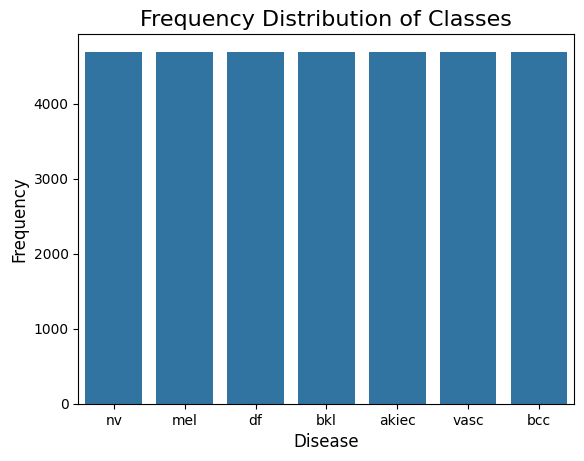

In [20]:
sns.countplot(x = 'dx', data = train_df_aug)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

In [21]:
img_name = "ISIC_0029306"
image = torchvision.io.read_image('HAM10000_images_all/' + img_name + ".jpg")
image.shape

torch.Size([3, 450, 600])

In [22]:
NUM_CLASSES = len(train_df_aug.dx.unique())

In [23]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [24]:
class SkinLesionClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = timm.create_model(model_name = "mobilenetv3_small_050", pretrained = True)

        self.intermediate_features = None  # Variable to store intermediate features

        def hook(module, input, output):
            self.intermediate_features = output

        self.hook_handle = self.model.blocks[5][0].conv.register_forward_hook(hook)

        num_in_features = self.model.get_classifier().in_features

        self.model.classifier = nn.Sequential(
            nn.BatchNorm1d(num_in_features),
            nn.Linear(in_features=num_in_features, out_features=512, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(in_features=512, out_features= self.num_classes, bias=False),
            #nn.Softmax(dim=-1) //Not needed here since softmax is done inside CrossEntropyLoss(), returning pure logits
        )

    def forward(self,X):
        return self.model(X)

    def cleanup_hooks(self):
        # Remove the hook after using it to avoid memory leaks
        self.hook_handle.remove()

In [25]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, labels, label_dict):
        #get all necessary inputs like train directories and labels
        self.df = df
        self.labels = labels
        self.labels = np.asarray(self.labels)
        self.label_dict = label_dict


    def __len__(self,):
        #return len of the dataset
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_id']
        img_label = self.df.iloc[idx]['dx']

        image = torchvision.io.read_image('HAM10000_images_all/' + img_name + ".jpg")
        # returns: int, Tensor, int
        return idx, image, self.label_dict.get(img_label)

In [26]:
label_dict = {'akiec' : 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv':5, 'vasc':6}

In [27]:
label_dict_reverse = {0 : 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5:'nv', 6:'vasc'}

In [28]:
train_dataset = SkinLesionDataset(train_df_aug, train_df_aug.dx.unique(), label_dict)
valid_dataset = SkinLesionDataset(val_df, val_df.dx.unique(), label_dict)

train_dataloader = DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle = True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = 64,
    shuffle = True
)

In [29]:
def train_one_epoch(model, dataloader, optimizer, loss_function, len_dataloader, device):
  model.train()
  total_epoch_loss = 0
  num_correct = 0

  dataloader = tqdm(dataloader)

  for i,(indices, images, labels) in enumerate(dataloader):
    images = images.float()
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    logits = model(images)
    loss = loss_function(logits, labels)

    loss.backward()
    optimizer.step()

    total_epoch_loss += loss.item()

    _, predicted = torch.max(logits, 1)
    num_correct += (predicted == labels).sum().item()


  return total_epoch_loss/len_dataloader, num_correct/len_dataloader

In [30]:
def load_train_save(load_path, save_path, epoch):
  model = SkinLesionClassifier(NUM_CLASSES).to(DEVICE)
  optimizer = Adam(lr = 0.001, params = model.parameters())
  criterion = nn.CrossEntropyLoss()

  if load_path:
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  start_time = timer()
  train_avg_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, criterion, len(train_dataset), DEVICE)
  end_time = timer()
  print(f"epoch : {epoch} | time elapsed : {end_time - start_time} | average loss : {train_avg_loss} | accuracy : {train_acc}")

  torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': train_avg_loss,
              }, save_path)


In [ ]:
load_train_save('mobilenetv3b64_epoch_9.pth', 'mobilenetv3b64_epoch_10.pth', 10)

Inference on validation data

In [31]:
val_df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,vidir_modern
1,4180,HAM_0000885,ISIC_0025293,nv,follow_up,40.0,female,upper extremity,vidir_molemax
2,3249,HAM_0004544,ISIC_0031099,nv,follow_up,50.0,male,foot,vidir_molemax
3,624,HAM_0002548,ISIC_0028656,bkl,histo,50.0,female,lower extremity,rosendahl
4,319,HAM_0007260,ISIC_0028336,bkl,histo,60.0,male,chest,rosendahl


In [32]:
def validate_model(model, dataloader, len_dataloader, device):
  model.eval()
  num_correct = 0

  dataloader = tqdm(dataloader)

  for i,(indices, images, labels) in enumerate(dataloader):
    images = images.float()
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)

    _, preds = torch.max(logits, 1)
    num_correct += (preds == labels).sum().item()

  return num_correct/len_dataloader

In [33]:
model = SkinLesionClassifier(NUM_CLASSES).to(DEVICE)
checkpoint = torch.load('mobilenetv3b64_epoch_10.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

<All keys matched successfully>

In [34]:
val_acc = validate_model(model, valid_dataloader, len(valid_dataset), DEVICE)
print(f"validation accuracy: {val_acc}")

  0%|          | 0/24 [00:00<?, ?it/s]

validation accuracy: 0.8768308921438083


Inference on test data

In [35]:
test_df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,547,HAM_0005335,ISIC_0031580,bkl,histo,40.0,male,upper extremity,rosendahl
1,8877,HAM_0006835,ISIC_0031594,nv,histo,75.0,male,chest,rosendahl
2,3696,HAM_0007205,ISIC_0026269,nv,follow_up,60.0,male,lower extremity,vidir_molemax
3,5850,HAM_0004072,ISIC_0032130,nv,follow_up,60.0,male,upper extremity,vidir_molemax
4,3371,HAM_0003341,ISIC_0027212,nv,follow_up,55.0,male,lower extremity,vidir_molemax


In [38]:
model = SkinLesionClassifier(NUM_CLASSES).to(DEVICE)
checkpoint = torch.load('mobilenetv3b64_epoch_10.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [39]:
#single inference example
model.eval()

test_image = torchvision.io.read_image("HAM10000_images_all/ISIC_0026269.jpg")
test_image = test_image.float()
test_image = test_image.to(DEVICE)
with torch.no_grad():
    logits = model(test_image.unsqueeze(0))
    print(f"image shape: {test_image.unsqueeze(0).shape}")
    features = model.intermediate_features

_, pred = torch.max(logits, 1)

print(pred)

label_text = test_df.loc[test_df["image_id"] == "ISIC_0026269"]['dx'].values[0]
print("Real class: " + str(label_dict[label_text]))
print("---------------------------------")
print(features.shape)

model.cleanup_hooks()

image shape: torch.Size([1, 3, 450, 600])
tensor([5], device='cuda:0')
Real class: 5
---------------------------------
torch.Size([1, 288, 15, 19])


In [40]:
test_results_df = test_df.copy()
test_results_df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,547,HAM_0005335,ISIC_0031580,bkl,histo,40.0,male,upper extremity,rosendahl
1,8877,HAM_0006835,ISIC_0031594,nv,histo,75.0,male,chest,rosendahl
2,3696,HAM_0007205,ISIC_0026269,nv,follow_up,60.0,male,lower extremity,vidir_molemax
3,5850,HAM_0004072,ISIC_0032130,nv,follow_up,60.0,male,upper extremity,vidir_molemax
4,3371,HAM_0003341,ISIC_0027212,nv,follow_up,55.0,male,lower extremity,vidir_molemax


In [41]:
def test_model_mcd(model, dataloader, len_dataloader, device, num_samples_per_inference, label_dict_reverse, test_results_df):
  model.eval()

  for m in model.modules():
    if isinstance(m, nn.Dropout): #for monte carlo dropout
      m.train()

  dataloader = tqdm(dataloader)

  num_correct = 0

  test_results_df["predicted_label"] = "x"
  test_results_df["is_prediction_correct"] = False
  test_results_df["prediction_variance"] = 0.0

  for i,(indices, images, labels) in enumerate(dataloader):
    batch_size = len(images)
    images = images.float()
    indices = indices.to(device)
    images = images.to(device)
    labels = labels.to(device)

    dropout_logits = []

    with torch.no_grad():
      for _ in range(num_samples_per_inference):
        logits = model(images)
        dropout_logits.append(logits)

    dropout_logits_tensor = torch.stack(dropout_logits)
    mean_logits = torch.mean(dropout_logits_tensor, dim=0)
    variances = torch.var(dropout_logits_tensor, dim=0)

    _, preds = torch.max(mean_logits, 1)
    num_correct += (preds == labels).sum().item()

    for j in range(batch_size):
        single_index = indices[j].cpu().item()
        single_prediction = preds[j]
        single_label = labels[j]
        single_label_variance = variances.cpu()[j][single_prediction]


        test_results_df.at[single_index, "predicted_label"] = label_dict_reverse[single_prediction.item()]
        test_results_df.at[single_index, "is_prediction_correct"] = (single_prediction.cpu() == single_label.cpu()).item()
        test_results_df.at[single_index, "prediction_variance"] = single_label_variance.item()

  return num_correct/len_dataloader, test_results_df

In [42]:
test_dataset = SkinLesionDataset(test_df, test_df.dx.unique(), label_dict)
test_dataloader = DataLoader(
    test_dataset,
    batch_size = 64,
    shuffle = False
)

In [43]:
test_mcd_accuracy, test_results_df = test_model_mcd(model, test_dataloader, len(test_dataset), DEVICE, 100, label_dict_reverse, test_results_df)
print(f"Test accuracy: {test_mcd_accuracy}")

  0%|          | 0/24 [00:00<?, ?it/s]

Test accuracy: 0.8616101131071191


In [44]:
#normalizing mean_variance column
test_results_df["prediction_variance"] = (test_results_df["prediction_variance"] - test_results_df["prediction_variance"].min()) / (test_results_df["prediction_variance"].max() - test_results_df["prediction_variance"].min())
test_results_df.head(20)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,predicted_label,is_prediction_correct,prediction_variance
0,547,HAM_0005335,ISIC_0031580,bkl,histo,40.0,male,upper extremity,rosendahl,bkl,True,0.072934
1,8877,HAM_0006835,ISIC_0031594,nv,histo,75.0,male,chest,rosendahl,bkl,False,0.094357
2,3696,HAM_0007205,ISIC_0026269,nv,follow_up,60.0,male,lower extremity,vidir_molemax,nv,True,0.084635
3,5850,HAM_0004072,ISIC_0032130,nv,follow_up,60.0,male,upper extremity,vidir_molemax,nv,True,0.081715
4,3371,HAM_0003341,ISIC_0027212,nv,follow_up,55.0,male,lower extremity,vidir_molemax,nv,True,0.043277
5,3951,HAM_0006311,ISIC_0024392,nv,follow_up,65.0,female,lower extremity,vidir_molemax,nv,True,0.059131
6,6283,HAM_0006562,ISIC_0031084,nv,follow_up,40.0,male,trunk,vidir_molemax,nv,True,0.091422
7,7386,HAM_0000579,ISIC_0032961,nv,histo,30.0,female,upper extremity,vidir_modern,nv,True,0.029515
8,6783,HAM_0002652,ISIC_0024934,nv,histo,25.0,male,lower extremity,vidir_modern,nv,True,0.102377
9,2125,HAM_0007070,ISIC_0032192,mel,histo,80.0,male,lower extremity,rosendahl,akiec,False,0.057358


In [45]:
test_results_df.to_csv('classification_test_results.csv')

Out of distribution detection using Mahalanobis distance over class conditional multivariate Gaussian distributions

In [46]:
def pool_and_flatten(feature_space, kernel_size, stride):
  feature_space = F.avg_pool2d(feature_space, kernel_size=kernel_size, stride=stride)

  # Continue pooling until the total size falls below 1e4
  while torch.numel(feature_space) >= 1e4:
      feature_space = F.avg_pool2d(feature_space, kernel_size=kernel_size, stride=stride)

  # Flatten the subspace
  feature_space = feature_space.view(-1)
  return feature_space

In [47]:
def get_features_stack(model, dataloader, len_dataloader, device):
  model.eval()

  dataloader = tqdm(dataloader)

  features_stack = None

  for i,(indices, images, labels) in enumerate(dataloader):
    batch_size = len(images)
    images = images.float()
    images = images.to(device)

    with torch.no_grad():
      _ = model(images)
      features = model.intermediate_features

    for j in range(batch_size):
        single_feature_space = pool_and_flatten(features[j], 2, 2)

        if i == 0 and j == 0:
          features_stack = single_feature_space.unsqueeze(0)
        else:
          features_stack = torch.cat((features_stack, single_feature_space.unsqueeze(0)), 0)

  return features_stack

In [48]:
def estimate_gaussian_mean(model, dataloader, len_dataloader, device):
  model.eval()

  dataloader = tqdm(dataloader)

  features_sum = None

  for i,(indices, images, labels) in enumerate(dataloader):
    batch_size = len(images)
    images = images.float()
    images = images.to(device)

    with torch.no_grad():
      _ = model(images)
      features = model.intermediate_features

    for j in range(batch_size):
        single_feature_space = pool_and_flatten(features[j], 2, 2)
        #single_feature_space = features[j].view(-1)

        if i == 0 and j == 0:
          features_sum = torch.zeros_like(single_feature_space)

        features_sum = torch.add(features_sum, single_feature_space)

  return torch.div(features_sum, len_dataloader)

In [49]:
def estimate_gaussian_covariance_matrix(model, dataloader, len_dataloader, device, gaussian_mean):
  model.eval()

  dataloader = tqdm(dataloader)

  outer_products_sum = None

  for i,(indices, images, labels) in enumerate(dataloader):
    batch_size = len(images)
    images = images.float()
    images = images.to(device)

    with torch.no_grad():
      logits = model(images)
      features = model.intermediate_features

    for j in range(batch_size):
        single_feature_space = pool_and_flatten(features[j], 2, 2)
        #single_feature_space = features[j].view(-1)

        if i == 0 and j == 0:
          outer_products_sum = torch.zeros_like(single_feature_space)

        diff = single_feature_space - gaussian_mean
        outer_product = torch.outer(diff, diff)

        outer_products_sum = torch.add(outer_products_sum,  outer_product)

  return outer_products_sum / len_dataloader

In [ ]:
model = SkinLesionClassifier(len(test_df.dx.unique())).to(DEVICE)
checkpoint = torch.load('mobilenetv3b64_epoch_10.pth')
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
train_dataset = SkinLesionDataset(train_df_aug, train_df_aug.dx.unique(), label_dict)

train_dataloader = DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle = True
)

In [ ]:
features_stack = get_features_stack(model, train_dataloader, len(train_dataset), DEVICE)
print(features_stack)
print(features_stack.shape)

In [ ]:
torch.save(features_stack, 'features_stack.pt')

In [ ]:
features_stack = torch.load('features_stack.pt')

In [ ]:
gaussian_mean = estimate_gaussian_mean(model, train_dataloader, len(train_dataset), DEVICE)
print(gaussian_mean)
print(gaussian_mean.shape)

In [ ]:
torch.save(gaussian_mean, 'gaussian_mean.pt')

In [ ]:
gaussian_covariance_matrix = estimate_gaussian_covariance_matrix(model, train_dataloader, len(train_dataset), DEVICE, gaussian_mean)
print(gaussian_covariance_matrix)
print(gaussian_covariance_matrix.shape)

In [ ]:
torch.save(gaussian_covariance_matrix, 'gaussian_covariance_matrix.pt')

In [50]:
gaussian_mean = torch.load('gaussian_mean.pt')
gaussian_covariance_matrix = torch.load('gaussian_covariance_matrix.pt')

In [51]:
# Adapted to Python from the MATLAB code found here: https://www.spg.tu-darmstadt.de/media/spg/ieee_ssrsp/material/SummerSchool_Ollila.pdf
def tylers_m_estimator(gaussian_covariance_matrix, diff_matrix, device):
  n, p = diff_matrix.shape
  prev_C = None
  inv_CO = torch.inverse(gaussian_covariance_matrix).to(device)
  epsilon = 0.001

  for i in range(300):
    if i % 100 == 0:
      print(i)
    t = torch.sum(diff_matrix @ inv_CO * diff_matrix, axis=1).to(device)
    u = torch.div(p, t).to(device)
    repmat = u.unsqueeze(1).repeat(1, p).to(device)
    C = (torch.t(diff_matrix) @ (diff_matrix * repmat) / n).to(device)
    C = C + torch.eye(p, device=device)
    d = torch.norm(torch.eye(p, device=device)  - inv_CO @ C, float('inf')).to(device)
    d = d.item()
    print(f"d: {d}")

    if d <= epsilon or math.isnan(d):
      break

    inv_CO = torch.inverse(C)
    prev_C = C

  return prev_C

In [ ]:
robust_covariance_matrix = tylers_m_estimator(gaussian_covariance_matrix.to(DEVICE), features_stack.to(DEVICE) - gaussian_mean.to(DEVICE), DEVICE)
print(robust_covariance_matrix)
print(robust_covariance_matrix.shape)

In [ ]:
torch.save(robust_covariance_matrix, 'robust_covariance_matrix.pt')

In [52]:
robust_covariance_matrix = torch.load('robust_covariance_matrix.pt')

In [53]:
def mahalanobis_distance(gaussian_mean, gaussian_covariance, flattened_feature_space):
  # gaussian_mean: tensor of size p x 1
  # gaussian_covariance: tensor of size p x p
  # feature_space: tensor of size p x 1
  diff = torch.sub(flattened_feature_space, gaussian_mean)
  inv = torch.linalg.inv(gaussian_covariance)
  return (diff.view(1,-1) @ inv @ diff).item()

In [54]:
def get_x_percent_boundary(distances, x):
  distances.sort()
  length = len(distances)
  return distances[int(length * (x/100))]

In [55]:
def save_mahalanobis_distances(model, dataloader, len_dataloader, device, gaussian_mean, covariance_matrix, save_name):
  model.eval()

  dataloader = tqdm(dataloader)

  mahalanobis_distances = []

  for i,(indices, images, labels) in enumerate(dataloader):
    batch_size = len(images)
    images = images.float()
    images = images.to(device)

    with torch.no_grad():
      _ = model(images)
      features = model.intermediate_features

    for j in range(batch_size):
        single_feature_space = pool_and_flatten(features[j], 2, 2)
        #single_feature_space = features[j].view(-1)

        mahalanobis_dist = mahalanobis_distance(gaussian_mean.to(device), covariance_matrix.to(device), single_feature_space.to(device))
        mahalanobis_distances.append(mahalanobis_dist)

  torch.save(mahalanobis_distances, save_name)


In [ ]:
save_mahalanobis_distances(model, train_dataloader, len(train_dataset), DEVICE, gaussian_mean, gaussian_covariance_matrix, 'mahalanobis_distances.pt')

In [ ]:
save_mahalanobis_distances(model, train_dataloader, len(train_dataset), DEVICE, gaussian_mean, robust_covariance_matrix, 'robust_mahalanobis_distances.pt')

In [56]:
mahalanobis_distances = torch.load('mahalanobis_distances.pt')

In [57]:
robust_mahalanobis_distances = torch.load('robust_mahalanobis_distances.pt')

In [58]:
ood_boundary = get_x_percent_boundary(mahalanobis_distances, 95)
print(f"ood boundary: {ood_boundary}")

ood boundary: 973.1948852539062


In [59]:
robust_ood_boundary = get_x_percent_boundary(robust_mahalanobis_distances, 95)
print(f"robust ood boundary: {robust_ood_boundary}")

robust ood boundary: 5.623986608546898e-26


------ TESTING OOD DETECTION ON VALIDATION AND TEST DATA --------

In [60]:
def is_sample_ood(flattened_feature_space, class_mean, class_covariance, class_boundary):
  return mahalanobis_distance(class_mean, class_covariance, flattened_feature_space) > class_boundary

In [61]:
def inference_and_ood_detection(model, dataloader, len_dataloader, device, num_samples_per_inference, label_dict_reverse, gaussian_mean, covariance_matrix, ood_boundary, num_classes, combined_results_df):
  model.eval()

  for m in model.modules():
    if isinstance(m, nn.Dropout): #for monte carlo dropout
      m.train()

  dataloader = tqdm(dataloader)

  num_correct = 0

  combined_results_df["predicted_label"] = "x"
  combined_results_df["is_prediction_correct"] = False
  combined_results_df["prediction_variance"] = 0.0
  combined_results_df["is_ood"] = False

  for i,(indices, images, labels) in enumerate(dataloader):
    batch_size = len(images)
    images = images.float()
    indices = indices.to(device)
    images = images.to(device)
    labels = labels.to(device)

    dropout_logits = []

    with torch.no_grad():
      for _ in range(num_samples_per_inference):
        logits = model(images)
        dropout_logits.append(logits)

      features = model.intermediate_features

    dropout_logits_tensor = torch.stack(dropout_logits)
    mean_logits = torch.mean(dropout_logits_tensor, dim=0)
    variances = torch.var(dropout_logits_tensor, dim=0)

    _, preds = torch.max(mean_logits, 1)
    num_correct += (preds == labels).sum().item()

    for j in range(batch_size):
        single_index = indices[j].cpu().item()
        single_prediction = preds[j]
        single_label = labels[j]
        single_label_variance = variances.cpu()[j][single_prediction]
        single_feature_space = pool_and_flatten(features[j], 2, 2)

        combined_results_df.at[single_index, "predicted_label"] = label_dict_reverse[single_prediction.item()]
        combined_results_df.at[single_index, "is_prediction_correct"] = (single_prediction.cpu() == single_label.cpu()).item()
        combined_results_df.at[single_index, "prediction_variance"] = single_label_variance.item()

        mahalanobis_distance_for_sample = mahalanobis_distance(gaussian_mean.to(device), covariance_matrix.to(device), single_feature_space.to(device))

        combined_results_df.at[single_index, "is_ood"] = mahalanobis_distance_for_sample > ood_boundary

  return num_correct/len_dataloader, combined_results_df

In [62]:
print(len(val_df))
val_df.head()

1502


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,vidir_modern
1,4180,HAM_0000885,ISIC_0025293,nv,follow_up,40.0,female,upper extremity,vidir_molemax
2,3249,HAM_0004544,ISIC_0031099,nv,follow_up,50.0,male,foot,vidir_molemax
3,624,HAM_0002548,ISIC_0028656,bkl,histo,50.0,female,lower extremity,rosendahl
4,319,HAM_0007260,ISIC_0028336,bkl,histo,60.0,male,chest,rosendahl


In [63]:
print(len(test_df))
test_df.head()

1503


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,547,HAM_0005335,ISIC_0031580,bkl,histo,40.0,male,upper extremity,rosendahl
1,8877,HAM_0006835,ISIC_0031594,nv,histo,75.0,male,chest,rosendahl
2,3696,HAM_0007205,ISIC_0026269,nv,follow_up,60.0,male,lower extremity,vidir_molemax
3,5850,HAM_0004072,ISIC_0032130,nv,follow_up,60.0,male,upper extremity,vidir_molemax
4,3371,HAM_0003341,ISIC_0027212,nv,follow_up,55.0,male,lower extremity,vidir_molemax


In [64]:
combined_df = pd.concat([val_df, test_df], ignore_index=True)
print(len(combined_df))
combined_df.head()

3005


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,vidir_modern
1,4180,HAM_0000885,ISIC_0025293,nv,follow_up,40.0,female,upper extremity,vidir_molemax
2,3249,HAM_0004544,ISIC_0031099,nv,follow_up,50.0,male,foot,vidir_molemax
3,624,HAM_0002548,ISIC_0028656,bkl,histo,50.0,female,lower extremity,rosendahl
4,319,HAM_0007260,ISIC_0028336,bkl,histo,60.0,male,chest,rosendahl


In [65]:
combined_dataset = SkinLesionDataset(combined_df, combined_df.dx.unique(), label_dict)

combined_dataloader = DataLoader(
    combined_dataset,
    batch_size = 64,
    shuffle = False
)

In [66]:
model = SkinLesionClassifier(len(test_df.dx.unique())).to(DEVICE)
checkpoint = torch.load('mobilenetv3b64_epoch_10.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [67]:
combined_accuracy, combined_results_df = inference_and_ood_detection(model, combined_dataloader, len(combined_dataset), DEVICE, 100, label_dict_reverse, gaussian_mean, gaussian_covariance_matrix, ood_boundary, NUM_CLASSES, combined_df)
print(combined_accuracy)
combined_results_df.head(20)

  0%|          | 0/47 [00:00<?, ?it/s]

0.870216306156406


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,predicted_label,is_prediction_correct,prediction_variance,is_ood
0,1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,vidir_modern,nv,False,0.775017,False
1,4180,HAM_0000885,ISIC_0025293,nv,follow_up,40.0,female,upper extremity,vidir_molemax,nv,True,1.090302,False
2,3249,HAM_0004544,ISIC_0031099,nv,follow_up,50.0,male,foot,vidir_molemax,nv,True,1.177969,False
3,624,HAM_0002548,ISIC_0028656,bkl,histo,50.0,female,lower extremity,rosendahl,bkl,True,1.212399,False
4,319,HAM_0007260,ISIC_0028336,bkl,histo,60.0,male,chest,rosendahl,nv,False,1.397078,False
5,7108,HAM_0006155,ISIC_0029728,nv,histo,35.0,female,face,vidir_modern,nv,True,1.071361,True
6,2951,HAM_0001390,ISIC_0027920,bcc,histo,75.0,male,face,vidir_modern,bcc,True,2.423383,False
7,3981,HAM_0003972,ISIC_0029706,nv,follow_up,40.0,female,trunk,vidir_molemax,nv,True,1.615533,False
8,3097,HAM_0002545,ISIC_0029149,nv,follow_up,45.0,female,lower extremity,vidir_molemax,nv,True,0.620421,False
9,4980,HAM_0007605,ISIC_0024699,nv,follow_up,25.0,female,trunk,vidir_molemax,nv,True,1.242699,False


In [68]:
combined_results_df.to_csv('combined_results.csv')

In [69]:
total_length = len(combined_results_df)
print(total_length)
print(len(combined_results_df.loc[combined_results_df['is_ood'] == True]) * 100 / total_length)

3005
18.668885191347755


In [70]:
# reset combined_df
combined_df = pd.concat([val_df, test_df], ignore_index=True)
print(len(combined_df))
combined_df.head()

3005


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,vidir_modern
1,4180,HAM_0000885,ISIC_0025293,nv,follow_up,40.0,female,upper extremity,vidir_molemax
2,3249,HAM_0004544,ISIC_0031099,nv,follow_up,50.0,male,foot,vidir_molemax
3,624,HAM_0002548,ISIC_0028656,bkl,histo,50.0,female,lower extremity,rosendahl
4,319,HAM_0007260,ISIC_0028336,bkl,histo,60.0,male,chest,rosendahl


In [71]:
combined_accuracy, combined_results_df = inference_and_ood_detection(model, combined_dataloader, len(combined_dataset), DEVICE, 100, label_dict_reverse, gaussian_mean, robust_covariance_matrix, robust_ood_boundary, NUM_CLASSES, combined_df)
print(combined_accuracy)
combined_results_df.head(20)

  0%|          | 0/47 [00:00<?, ?it/s]

0.870216306156406


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,predicted_label,is_prediction_correct,prediction_variance,is_ood
0,1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,vidir_modern,nv,False,0.625218,False
1,4180,HAM_0000885,ISIC_0025293,nv,follow_up,40.0,female,upper extremity,vidir_molemax,nv,True,0.924816,False
2,3249,HAM_0004544,ISIC_0031099,nv,follow_up,50.0,male,foot,vidir_molemax,nv,True,1.279781,False
3,624,HAM_0002548,ISIC_0028656,bkl,histo,50.0,female,lower extremity,rosendahl,bkl,True,1.005309,False
4,319,HAM_0007260,ISIC_0028336,bkl,histo,60.0,male,chest,rosendahl,nv,False,1.736824,False
5,7108,HAM_0006155,ISIC_0029728,nv,histo,35.0,female,face,vidir_modern,nv,True,1.085382,False
6,2951,HAM_0001390,ISIC_0027920,bcc,histo,75.0,male,face,vidir_modern,bcc,True,2.310283,False
7,3981,HAM_0003972,ISIC_0029706,nv,follow_up,40.0,female,trunk,vidir_molemax,nv,True,1.202524,False
8,3097,HAM_0002545,ISIC_0029149,nv,follow_up,45.0,female,lower extremity,vidir_molemax,nv,True,0.562869,False
9,4980,HAM_0007605,ISIC_0024699,nv,follow_up,25.0,female,trunk,vidir_molemax,nv,True,0.930222,False


In [72]:
combined_results_df.to_csv('combined_results_robust.csv')

In [73]:
total_length = len(combined_results_df)
print(total_length)
print(len(combined_results_df.loc[combined_results_df['is_ood'] == True]) * 100 / total_length)

3005
6.75540765391015


--------- OOD DETECTION TESTING ON FAR-OOD DATA ----------

HRCT Chest Covid Data -CT SCAN dataset on Kaggle:
https://www.kaggle.com/datasets/nazmul0087/hrct-chest-covid-data-ct-scan?resource=download

In [74]:
ct_metadata_df = pd.read_csv('HRCTChestCovid_metadata.csv')
ct_metadata_df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Normal- (1691),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
1,1,Normal- (1754),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
2,2,Normal- (3506),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
3,3,Normal- (316),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
4,4,Normal- (2968),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy


In [75]:
img_name = "Normal- (999)"
image = torchvision.io.read_image('HRCTChestCovid_all/' + img_name + ".jpg")
print(image.shape)

resize_transform = transforms.Resize((450, 600))
image = resize_transform(image)
print(image.shape)

torch.Size([3, 768, 768])
torch.Size([3, 450, 600])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [76]:
class ChestCTDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.resize_transform = transforms.Resize((450, 600))

    def __len__(self,):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_id']
        image = torchvision.io.read_image('HRCTChestCovid_all/' + img_name + ".jpg")
        resized_image = self.resize_transform(image)
        return idx, resized_image

In [77]:
def far_ood_detection(model, dataloader, device, gaussian_mean, covariance_matrix, ood_boundary, ct_ood_results_df):
  model.eval()

  for m in model.modules():
    if isinstance(m, nn.Dropout):
      m.train()

  dataloader = tqdm(dataloader)

  ct_ood_results_df["is_ood"] = False

  for i,(indices, images) in enumerate(dataloader):
    batch_size = len(images)
    images = images.float()
    images = images.to(device)

    with torch.no_grad():
      _ = model(images)
      features = model.intermediate_features

    for j in range(batch_size):
        single_index = indices[j].cpu().item()
        single_feature_space = pool_and_flatten(features[j], 2, 2)

        mahalanobis_distance_for_sample = mahalanobis_distance(gaussian_mean.to(device), covariance_matrix.to(device), single_feature_space.to(device))

        ct_ood_results_df.at[single_index, "is_ood"] = mahalanobis_distance_for_sample > ood_boundary

  return ct_ood_results_df

In [90]:
ct_dataset = ChestCTDataset(ct_metadata_df)

ct_dataloader = DataLoader(
    ct_dataset,
    batch_size = 64,
    shuffle = False
)

In [89]:
model = SkinLesionClassifier(len(test_df.dx.unique())).to(DEVICE)
checkpoint = torch.load('mobilenetv3b64_epoch_10.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [80]:
ct_ood_results_df = ct_metadata_df.copy()
ct_ood_results_df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Normal- (1691),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
1,1,Normal- (1754),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
2,2,Normal- (3506),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
3,3,Normal- (316),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
4,4,Normal- (2968),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy


In [82]:
ct_ood_results_df = far_ood_detection(model, ct_dataloader, DEVICE, gaussian_mean, gaussian_covariance_matrix, ood_boundary, ct_ood_results_df)
ct_ood_results_df.head(10)

  0%|          | 0/96 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


,Unnamed: 0,image_id,path,diag,target,Class,is_ood
0,0,Normal- (1691),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
1,1,Normal- (1754),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
2,2,Normal- (3506),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
3,3,Normal- (316),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
4,4,Normal- (2968),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
5,5,Normal- (2647),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
6,6,Normal- (2697),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
7,7,Normal- (1181),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
8,8,Normal- (2343),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
9,9,Normal- (3139),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True


In [83]:
print(len(ct_ood_results_df.loc[ct_ood_results_df['is_ood'] == True]) * 100 / (len(ct_ood_results_df)))

99.98355804011838


In [84]:
ct_ood_results_df.to_csv('far_ood_results_df.csv')

In [91]:
# reset ct_ood_results_df
ct_ood_results_df = ct_metadata_df.copy()
ct_ood_results_df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Normal- (1691),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
1,1,Normal- (1754),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
2,2,Normal- (3506),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
3,3,Normal- (316),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy
4,4,Normal- (2968),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy


In [92]:
ct_ood_results_df = far_ood_detection(model, ct_dataloader, DEVICE, gaussian_mean, robust_covariance_matrix, robust_ood_boundary, ct_ood_results_df)
ct_ood_results_df.head(10)

  0%|          | 0/96 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


,Unnamed: 0,image_id,path,diag,target,Class,is_ood
0,0,Normal- (1691),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,False
1,1,Normal- (1754),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
2,2,Normal- (3506),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
3,3,Normal- (316),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,False
4,4,Normal- (2968),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,False
5,5,Normal- (2647),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,False
6,6,Normal- (2697),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
7,7,Normal- (1181),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
8,8,Normal- (2343),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,True
9,9,Normal- (3139),/content/data/HRCT Chest Covid Data CT SCAN/No...,Normal,1,Healthy,False


In [93]:
print(len(ct_ood_results_df.loc[ct_ood_results_df['is_ood'] == True]) * 100 / (len(ct_ood_results_df)))

28.099309437684973


In [120]:
ct_ood_results_df.to_csv('far_ood_results_df_robust.csv')

--------- OOD DETECTION TESTING ON NEAR-OOD DATA ----------

Hospital Italiano de Buenos Aires - Skin Lesions Images (2019-2022): https://api.isic-archive.com/collections/251/?page=54#

In [94]:
ba_metadata_df = pd.read_csv('buenos_aires_skin_lesions_metadata.csv')
ba_metadata_df.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,sex
0,ISIC_0079358,Hospital Italiano de Buenos Aires,CC-BY,35.0,anterior torso,benign,contact polarized,nevus,NaN,False,dermoscopic,IL_3989348,IP_9328831,False,female
1,ISIC_0086914,Hospital Italiano de Buenos Aires,CC-BY,55.0,upper extremity,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_9767756,IP_7506563,True,male
2,ISIC_0088904,Hospital Italiano de Buenos Aires,CC-BY,50.0,NaN,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_8711401,IP_0222733,False,female
3,ISIC_0094098,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,NaN,melanoma,histopathology,False,clinical: overview,IL_6961144,IP_1218261,True,male
4,ISIC_0095134,Hospital Italiano de Buenos Aires,CC-BY,70.0,anterior torso,malignant,contact polarized,melanoma,histopathology,False,dermoscopic,IL_4530268,IP_8235588,True,female


In [95]:
label_list = ba_metadata_df.diagnosis.unique()
for label in label_list:
  print(label)
print(len(ba_metadata_df))

nevus
basal cell carcinoma
melanoma
vascular lesion
seborrheic keratosis
actinic keratosis
squamous cell carcinoma
dermatofibroma
solar lentigo
lichenoid keratosis
1616


In [96]:
id_label_list = train_df_aug.dx.unique()
for id_label in id_label_list:
  print(id_label)

nv
mel
df
bkl
akiec
vasc
bcc


In [97]:
print(len(ba_metadata_df))
ba_metadata_df_filtered = ba_metadata_df[ba_metadata_df.diagnosis != "lichenoid keratosis"]
ba_metadata_df_filtered = ba_metadata_df_filtered[ba_metadata_df_filtered.diagnosis != "actinic keratosis"]
ba_metadata_df_filtered = ba_metadata_df_filtered[ba_metadata_df_filtered.diagnosis != "solar lentigo"]
ba_metadata_df_filtered.head()
len(ba_metadata_df_filtered)

1616


1533


1.   Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
2.   basal cell carcinoma (bcc)
3.   benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
4.   dermatofibroma (df)
5.   melanoma (mel)
6.   melanocytic nevi (nv)
7.   vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)




In [98]:
label_map = {"nv" : "nevus", "mel" : "melanoma", "bcc": "basal cell carcinoma", "vasc" : "vascular lesion", "bkl" : "seborrheic keratosis", "df" : "dermatofibroma", "akiec" : "squamous cell carcinoma", "bcc" : "basal cell carcinoma"}

In [99]:
reverse_label_map = {"nevus" : "nv", "melanoma" : "mel", "basal cell carcinoma": "bcc", "vascular lesion" : "vasc", "seborrheic keratosis" : "bkl", "dermatofibroma" : "df", "squamous cell carcinoma" : "akiec", "basal cell carcinoma" : "bcc"}

In [100]:
img_name = "ISIC_7874486"
image = torchvision.io.read_image('buenos_aires_skin_lesion_images_all/' + img_name + ".JPG")
image.shape

torch.Size([3, 2904, 1412])

In [101]:
class BuenorAiresSLDataset(Dataset):
    def __init__(self, df, labels, label_dict, reverse_label_map):
        self.df = df
        self.resize_transform = transforms.Resize((450, 600))
        self.labels = labels
        self.labels = np.asarray(self.labels)
        self.label_dict = label_dict
        self.reverse_label_map = reverse_label_map

    def __len__(self,):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['isic_id']
        img_label = self.df.iloc[idx]['diagnosis']

        image = torchvision.io.read_image('buenos_aires_skin_lesion_images_all/' + img_name + ".JPG")
        resized_image = self.resize_transform(image)

        return idx, resized_image, self.label_dict.get(self.reverse_label_map.get(img_label))

In [102]:
def near_ood_detection_and_inference(model, dataloader, len_dataloader, device, num_samples_per_inference, label_dict_reverse, label_map, gaussian_mean, covariance_matrix, ood_boundary, num_classes, ba_results_df):
  model.eval()

  for m in model.modules():
    if isinstance(m, nn.Dropout): #for monte carlo dropout
      m.train()

  dataloader = tqdm(dataloader)

  num_correct = 0

  ba_results_df["predicted_label"] = "x"
  ba_results_df["is_prediction_correct"] = False
  ba_results_df["prediction_variance"] = 0.0
  ba_results_df["is_ood"] = False

  for i,(indices, images, labels) in enumerate(dataloader):
    batch_size = len(images)
    images = images.float()
    indices = indices.to(device)
    images = images.to(device)
    labels = labels.to(device)

    dropout_logits = []

    with torch.no_grad():
      for _ in range(num_samples_per_inference):
        logits = model(images)
        dropout_logits.append(logits)

      features = model.intermediate_features

    dropout_logits_tensor = torch.stack(dropout_logits)
    mean_logits = torch.mean(dropout_logits_tensor, dim=0)
    variances = torch.var(dropout_logits_tensor, dim=0)

    _, preds = torch.max(mean_logits, 1)
    num_correct += (preds == labels).sum().item()

    for j in range(batch_size):
        single_index = indices[j].cpu().item()
        single_prediction = preds[j]
        single_label = labels[j]
        single_label_variance = variances.cpu()[j][single_prediction]
        single_feature_space = pool_and_flatten(features[j], 2, 2)

        ba_results_df.at[single_index, "predicted_label"] = label_map[label_dict_reverse[single_prediction.item()]]
        ba_results_df.at[single_index, "is_prediction_correct"] = (single_prediction.cpu() == single_label.cpu()).item()
        ba_results_df.at[single_index, "prediction_variance"] = single_label_variance.item()

        mahalanobis_distance_for_sample = mahalanobis_distance(gaussian_mean.to(device), covariance_matrix.to(device), single_feature_space.to(device))

        ba_results_df.at[single_index, "is_ood"] = mahalanobis_distance_for_sample > ood_boundary

  return num_correct/len_dataloader, ba_results_df

In [126]:
ba_dataset = BuenorAiresSLDataset(ba_metadata_df_filtered, ba_metadata_df_filtered.diagnosis.unique(), label_dict, reverse_label_map)

ba_dataloader = DataLoader(
    ba_dataset,
    batch_size = 64,
    shuffle = False
)

In [127]:
model = SkinLesionClassifier(len(test_df.dx.unique())).to(DEVICE)
checkpoint = torch.load('mobilenetv3b64_epoch_10.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [118]:
ba_ood_results_df = ba_metadata_df_filtered.copy()
ba_ood_results_df.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,sex
0,ISIC_0079358,Hospital Italiano de Buenos Aires,CC-BY,35.0,anterior torso,benign,contact polarized,nevus,NaN,False,dermoscopic,IL_3989348,IP_9328831,False,female
1,ISIC_0086914,Hospital Italiano de Buenos Aires,CC-BY,55.0,upper extremity,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_9767756,IP_7506563,True,male
2,ISIC_0088904,Hospital Italiano de Buenos Aires,CC-BY,50.0,NaN,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_8711401,IP_0222733,False,female
3,ISIC_0094098,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,NaN,melanoma,histopathology,False,clinical: overview,IL_6961144,IP_1218261,True,male
4,ISIC_0095134,Hospital Italiano de Buenos Aires,CC-BY,70.0,anterior torso,malignant,contact polarized,melanoma,histopathology,False,dermoscopic,IL_4530268,IP_8235588,True,female


In [119]:
near_ood_accuracy, ba_ood_results_df = near_ood_detection_and_inference(model, ba_dataloader, len(ba_dataset), DEVICE, 100, label_dict_reverse, label_map, gaussian_mean, gaussian_covariance_matrix, ood_boundary, NUM_CLASSES, ba_ood_results_df)
print(near_ood_accuracy)
ba_ood_results_df.head(10)

  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

0.4090019569471624


,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,sex,predicted_label,is_prediction_correct,prediction_variance,is_ood
0,ISIC_0079358,Hospital Italiano de Buenos Aires,CC-BY,35.0,anterior torso,benign,contact polarized,nevus,NaN,False,dermoscopic,IL_3989348,IP_9328831,False,female,nevus,True,0.771334,False
1,ISIC_0086914,Hospital Italiano de Buenos Aires,CC-BY,55.0,upper extremity,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_9767756,IP_7506563,True,male,melanoma,False,0.890112,True
2,ISIC_0088904,Hospital Italiano de Buenos Aires,CC-BY,50.0,NaN,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_8711401,IP_0222733,False,female,nevus,False,0.708259,True
3,ISIC_0094098,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,NaN,melanoma,histopathology,False,clinical: overview,IL_6961144,IP_1218261,True,male,nevus,False,1.369871,True
4,ISIC_0095134,Hospital Italiano de Buenos Aires,CC-BY,70.0,anterior torso,malignant,contact polarized,melanoma,histopathology,False,dermoscopic,IL_4530268,IP_8235588,True,female,nevus,False,1.362541,True
5,ISIC_0107741,Hospital Italiano de Buenos Aires,CC-BY,70.0,lower extremity,benign,NaN,vascular lesion,NaN,True,clinical: overview,IL_2965116,IP_0276872,NaN,male,nevus,False,1.656727,False
6,ISIC_0115851,Hospital Italiano de Buenos Aires,CC-BY,30.0,lateral torso,benign,contact polarized,nevus,histopathology,False,dermoscopic,IL_3312003,IP_9935521,False,male,melanoma,False,0.843876,False
7,ISIC_0116640,Hospital Italiano de Buenos Aires,CC-BY,80.0,lower extremity,malignant,NaN,melanoma,histopathology,True,clinical: overview,IL_5502639,IP_7526334,True,female,basal cell carcinoma,False,2.526305,False
8,ISIC_0119854,Hospital Italiano de Buenos Aires,CC-BY,80.0,anterior torso,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical: overview,IL_9587318,IP_2079372,NaN,female,basal cell carcinoma,True,2.228096,True
9,ISIC_0133379,Hospital Italiano de Buenos Aires,CC-BY,65.0,head/neck,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical: overview,IL_3383993,IP_3342129,NaN,female,nevus,False,0.545210,True


In [121]:
print(len(ba_ood_results_df.loc[ba_ood_results_df['is_ood'] == True]) * 100 / (len(ba_ood_results_df)))
print(len(ba_ood_results_df.loc[(ba_ood_results_df['is_prediction_correct'] == False) & (ba_ood_results_df['is_ood'] == True)]) * 100 / len(ba_ood_results_df.loc[ba_ood_results_df['is_prediction_correct'] == False]))
print(len(ba_ood_results_df.loc[(ba_ood_results_df['is_prediction_correct'] == True) & (ba_ood_results_df['is_ood'] == True)]) * 100 / len(ba_ood_results_df.loc[ba_ood_results_df['is_prediction_correct'] == True]) )

76.36476426799007
76.44670050761421
76.2360446570973


In [122]:
ba_ood_results_df.to_csv('near_ood_results_df.csv')

In [125]:
# reset ba_ood_results_df
ba_ood_results_df = ba_metadata_df_filtered.copy()
ba_ood_results_df.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,sex
0,ISIC_0079358,Hospital Italiano de Buenos Aires,CC-BY,35.0,anterior torso,benign,contact polarized,nevus,NaN,False,dermoscopic,IL_3989348,IP_9328831,False,female
1,ISIC_0086914,Hospital Italiano de Buenos Aires,CC-BY,55.0,upper extremity,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_9767756,IP_7506563,True,male
2,ISIC_0088904,Hospital Italiano de Buenos Aires,CC-BY,50.0,NaN,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_8711401,IP_0222733,False,female
3,ISIC_0094098,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,NaN,melanoma,histopathology,False,clinical: overview,IL_6961144,IP_1218261,True,male
4,ISIC_0095134,Hospital Italiano de Buenos Aires,CC-BY,70.0,anterior torso,malignant,contact polarized,melanoma,histopathology,False,dermoscopic,IL_4530268,IP_8235588,True,female


In [128]:
near_ood_accuracy, ba_ood_results_df = near_ood_detection_and_inference(model, ba_dataloader, len(ba_dataset), DEVICE, 100, label_dict_reverse, label_map, gaussian_mean, robust_covariance_matrix, robust_ood_boundary, NUM_CLASSES, ba_ood_results_df)
print(near_ood_accuracy)
ba_ood_results_df.head(10)

  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

0.4024787997390737


,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,sex,predicted_label,is_prediction_correct,prediction_variance,is_ood
0,ISIC_0079358,Hospital Italiano de Buenos Aires,CC-BY,35.0,anterior torso,benign,contact polarized,nevus,NaN,False,dermoscopic,IL_3989348,IP_9328831,False,female,nevus,True,0.881581,False
1,ISIC_0086914,Hospital Italiano de Buenos Aires,CC-BY,55.0,upper extremity,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_9767756,IP_7506563,True,male,melanoma,False,1.072152,False
2,ISIC_0088904,Hospital Italiano de Buenos Aires,CC-BY,50.0,NaN,malignant,contact polarized,basal cell carcinoma,histopathology,False,dermoscopic,IL_8711401,IP_0222733,False,female,nevus,False,0.854014,False
3,ISIC_0094098,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,NaN,melanoma,histopathology,False,clinical: overview,IL_6961144,IP_1218261,True,male,nevus,False,1.296173,False
4,ISIC_0095134,Hospital Italiano de Buenos Aires,CC-BY,70.0,anterior torso,malignant,contact polarized,melanoma,histopathology,False,dermoscopic,IL_4530268,IP_8235588,True,female,nevus,False,1.553431,False
5,ISIC_0107741,Hospital Italiano de Buenos Aires,CC-BY,70.0,lower extremity,benign,NaN,vascular lesion,NaN,True,clinical: overview,IL_2965116,IP_0276872,NaN,male,nevus,False,2.204088,False
6,ISIC_0115851,Hospital Italiano de Buenos Aires,CC-BY,30.0,lateral torso,benign,contact polarized,nevus,histopathology,False,dermoscopic,IL_3312003,IP_9935521,False,male,melanoma,False,1.085819,False
7,ISIC_0116640,Hospital Italiano de Buenos Aires,CC-BY,80.0,lower extremity,malignant,NaN,melanoma,histopathology,True,clinical: overview,IL_5502639,IP_7526334,True,female,basal cell carcinoma,False,2.914179,False
8,ISIC_0119854,Hospital Italiano de Buenos Aires,CC-BY,80.0,anterior torso,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical: overview,IL_9587318,IP_2079372,NaN,female,basal cell carcinoma,True,2.121926,True
9,ISIC_0133379,Hospital Italiano de Buenos Aires,CC-BY,65.0,head/neck,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical: overview,IL_3383993,IP_3342129,NaN,female,nevus,False,0.600971,False


In [129]:
print(len(ba_ood_results_df.loc[ba_ood_results_df['is_ood'] == True]) * 100 / (len(ba_ood_results_df)))
print(len(ba_ood_results_df.loc[(ba_ood_results_df['is_prediction_correct'] == False) & (ba_ood_results_df['is_ood'] == True)]) * 100 / len(ba_ood_results_df.loc[ba_ood_results_df['is_prediction_correct'] == False]))
print(len(ba_ood_results_df.loc[(ba_ood_results_df['is_prediction_correct'] == True) & (ba_ood_results_df['is_ood'] == True)]) * 100 / len(ba_ood_results_df.loc[ba_ood_results_df['is_prediction_correct'] == True]) )

13.027295285359802
12.56281407035176
13.776337115072934


In [130]:
ba_ood_results_df.to_csv('near_ood_results_df_robust.csv')

In [131]:
model.cleanup_hooks()